In [1]:
from collections import Counter, defaultdict, deque
from functools import partial
from itertools import chain, cycle, product

from joblib import Parallel, delayed

import numpy as np

In [2]:
# consider lanes with largest index first
def lane_index_priority(lane_tuple, product=None, boxes=None):

    if product is None or boxes is None:
        raise RuntimeError("No product or boxes set")

    return (lane_tuple[0], -boxes[lane_tuple[0]])


# consider lane with largest sum number of products first
def sum_of_products_priority(lane_tuple, product=None, boxes=None):

    if product is None or boxes is None:
        raise RuntimeError("No product or boxes set")

    return (sum(lane_tuple[1].values()), -boxes[lane_tuple[0]])


# consider lane with largest product count first, ex: largest number of As
def product_count_priority(lane_tuple, product=None, boxes=None):

    if product is None or boxes is None:
        raise RuntimeError("No product or boxes set")

    return (lane_tuple[1][product], -boxes[lane_tuple[0]])


# priority based on randomly generated numbers
def random_priority(lane_tuple, product=None, boxes=None):

    if product is None or boxes is None:
        raise RuntimeError("No product or boxes set")

    return (np.random.rand(), -boxes[lane_tuple[0]])

In [3]:
def generate_sequential_batches(batch_size, recipe, sample_size):
    products = list(recipe.keys())
    totals = list(recipe.values())
    num_of_batches = np.ceil(sample_size / batch_size).astype(int)

    counts = dict(sorted(zip(products, totals), key=lambda x: x[1], reverse=True))

    pattern = []
    while 0 < sum(counts.values()):
        for product in counts.keys():
            if 0 < counts[product]:
                pattern.append(product)
                counts[product] -= 1

    out = []
    for index, product in zip(range(num_of_batches), cycle(pattern)):
        out.append(product)

    return out


def generate_random_products(recipe, sample_size):
    products = list(recipe.keys())
    return np.random.choice(
        products,
        size=sample_size,
        p=[t / sum(recipe.values()) for t in recipe.values()],
    ).tolist()

In [4]:
recipes = [
    {"A": 8, "B": 4, "C": 4, "D": 8, "E": 10, "F": 16},
    {"A": 10, "B": 10, "C": 6, "D": 4},
    {"A": 3, "B": 3, "C": 4, "D": 3, "E": 3, "F": 2},
]
batch_sizes = [25, 50, 100]
sample_size = 15000
lane_lock = 25
priority = product_count_priority
products_per_min = 250

In [5]:
def create_infeed_types():
    sequences = {}

    for i, batch_size in product(range(len(recipes)), batch_sizes):
        sequences[(i, "sequential_batches", batch_size)] = generate_sequential_batches(
            batch_size, recipes[i], sample_size
        )

    for i, recipe in enumerate(recipes):
        sequences[(i, "random_products", None)] = generate_random_products(
            recipe, sample_size
        )

    return sequences


sequences = create_infeed_types()

In [6]:
a = np.zeros((2, 2))
a[[True, False],:] += 1
a

array([[1., 1.],
       [0., 0.]])

In [7]:
a = np.zeros((2, 2))
v = a[[True, False],:]
v += 1
print(v)
a += v
a

[[1. 1.]]


array([[1., 1.],
       [1., 1.]])

In [8]:
a = np.zeros((2, 2))
a[:,2] += 1
a

IndexError: index 2 is out of bounds for axis 1 with size 2

In [11]:
a = np.arange(3)
mask = np.array([True, False, True])
order = np.array([1, 0, 2])

In [12]:
a[mask[order]]

array([1, 2])

In [29]:
num_of_products = 6

num_of_lanes = 5

infeed = np.random.randint(num_of_products, size=1000)

products = np.array([8, 4, 4, 8, 10, 16])

In [30]:
locks = np.zeros(num_of_lanes)

states = np.zeros((num_of_lanes, num_of_products))

recirculation = 0

for i in list(range(infeed.size)):
#     print(f"iteration {i}")
    
    p = infeed[i]
#     print(p)
    
    available = locks == 0
#     print(available)
    
    fits = states[:,p] < products[p]
#     print(fits)
    
    mask = available & fits
#     print(mask)
    
    order = np.argsort(-states[:,p])
#     print(order)
    
    if order[mask[order]].size == 0:
        recirculation += 1
    else:
        l = order[mask[order]][0]
#         print(l)
        states[l,p] += 1    

#     print(states)
#     print(recirculation)
    
    # drop locks
    locks[~available] -= 1
    
    
    # check if lanes are full
    full = np.all(states == products.reshape(1, -1), axis=1)
    
    # lock and reset
    locks[full] = 25
    states[full,:] = 0
    
    
#     print(full)
    
#     print("---------------")

In [31]:
recirculation

345

In [6]:
def simulate(num_of_lanes, infeed_type, recipe_index, batch_size=None):

    # split recipes into products and totals
    recipe = recipes[recipe_index]
    products = list(recipe.keys())
    totals = list(recipe.values())

    # Initialize data containers
    batch_order = []
    lanes = {i: {p: 0 for p in products + ["lock"]} for i in range(num_of_lanes)}
    boxes_per_lane = {i: 0 for i in range(num_of_lanes)}
    boxes_per_lane_per_frame = {i: [] for i in range(num_of_lanes)}
    recirculation = []

    # Initialize product queue will get updated based on infeed system
    product_queue = deque()

    # init product queue base on infeed type
    if infeed_type == "sequential_batches":

        if batch_size is None:
            raise RuntimeError(f"batch_size must be specified")

        batches_queue = deque(sequences[(recipe_index, infeed_type, batch_size)])
        next_batch = batches_queue.popleft()
        batch_order.append(next_batch)

        product_queue.extend([next_batch] * batch_size)

    elif infeed_type == "random_products":

        product_queue.extend(sequences[(recipe_index, infeed_type, None)])

    else:
        raise RuntimeError(f"infeed_type {infeed_type} if unknown!")

    product_counter = 0
    while product_counter < sample_size:

        product = product_queue.popleft()
        consumed = False
        for i, lane in sorted(
            lanes.items(),
            key=partial(priority, product=product, boxes=boxes_per_lane),
            reverse=True,
        ):

            # Lane is available to accept products
            lane_is_available = lane["lock"] == 0

            # Lane has space to accept product
            product_fits = lane[product] < recipe[product]

            # Complete cases for 3 binary variables
            if not consumed and lane_is_available and product_fits:
                lane[product] += 1
                consumed = True

            elif not consumed and lane_is_available and not product_fits:
                continue

            elif not consumed and not lane_is_available and product_fits:
                lane["lock"] -= 1

            elif not consumed and not lane_is_available and not product_fits:
                lane["lock"] -= 1

            elif consumed and lane_is_available and product_fits:
                continue

            elif consumed and lane_is_available and not product_fits:
                continue

            elif consumed and not lane_is_available and product_fits:
                lane["lock"] -= 1

            elif consumed and not lane_is_available and not product_fits:
                lane["lock"] -= 1

        # recirculation un-consumed products
        if not consumed:
            recirculation.append(product)

        # Lane is ready to be boxed
        for j in lanes:
            boxes_per_lane_per_frame[j].append(0)
            if all(lanes[j][p] == recipe[p] for p in products):
                lanes[j] = {p: 0 for p in products + ["lock"]}
                lanes[j]["lock"] = lane_lock
                boxes_per_lane[j] += 1
                boxes_per_lane_per_frame[j][product_counter] = 1

        # continue onto the next product
        product_counter += 1

        # check if the queue is empty
        if (
            len(product_queue) == 0
            and infeed_type == "sequential_batches"
            and product_counter < sample_size
        ):
            next_batch = batches_queue.popleft()
            batch_order.append(next_batch)
            product_queue.extend([next_batch] * batch_size)

    return {
        "recirculation": len(recirculation),
        "sample_size": sample_size,
        "box_products": sum(recipe.values()) * sum(boxes_per_lane.values()),
        "unbox_products": sample_size
        - len(recirculation)
        - sum(recipe.values()) * sum(boxes_per_lane.values()),
        "boxes_per_lane": boxes_per_lane,
        "boxes": sum(boxes_per_lane.values()),
        "boxes_per_lane_per_frame": boxes_per_lane_per_frame,
        "batch_order": batch_order,
    }

In [7]:
out = simulate(5, "random_products", 0)
out.pop("boxes_per_lane_per_frame")
out

{'recirculation': 303,
 'sample_size': 15000,
 'box_products': 14600,
 'unbox_products': 97,
 'boxes_per_lane': {0: 59, 1: 59, 2: 58, 3: 58, 4: 58},
 'boxes': 292,
 'batch_order': []}

In [8]:
out = simulate(5, "sequential_batches", 0, batch_size=50)
out.pop("boxes_per_lane_per_frame")
batch_counts = Counter(out.pop("batch_order"))
print({k: round(value / min(batch_counts.values()), 2) for k, value in sorted(batch_counts.items())})
print({k: round(value / min(recipes[0].values()), 2) for k, value in sorted(recipes[0].items())})
out

{'A': 2.0, 'B': 1.0, 'C': 1.0, 'D': 2.0, 'E': 2.5, 'F': 4.0}
{'A': 2.0, 'B': 1.0, 'C': 1.0, 'D': 2.0, 'E': 2.5, 'F': 4.0}


{'recirculation': 9190,
 'sample_size': 15000,
 'box_products': 5600,
 'unbox_products': 210,
 'boxes_per_lane': {0: 23, 1: 23, 2: 22, 3: 22, 4: 22},
 'boxes': 112}

In [9]:
def get_the_ys(xx, infeed_type, recipe_index, batch_size=None):
    data = Parallel(n_jobs=4)(
        delayed(simulate)(x, infeed_type, recipe_index, batch_size=batch_size)
        for x in xx
    )
    return [d["box_products"] / d["sample_size"] for d in data]

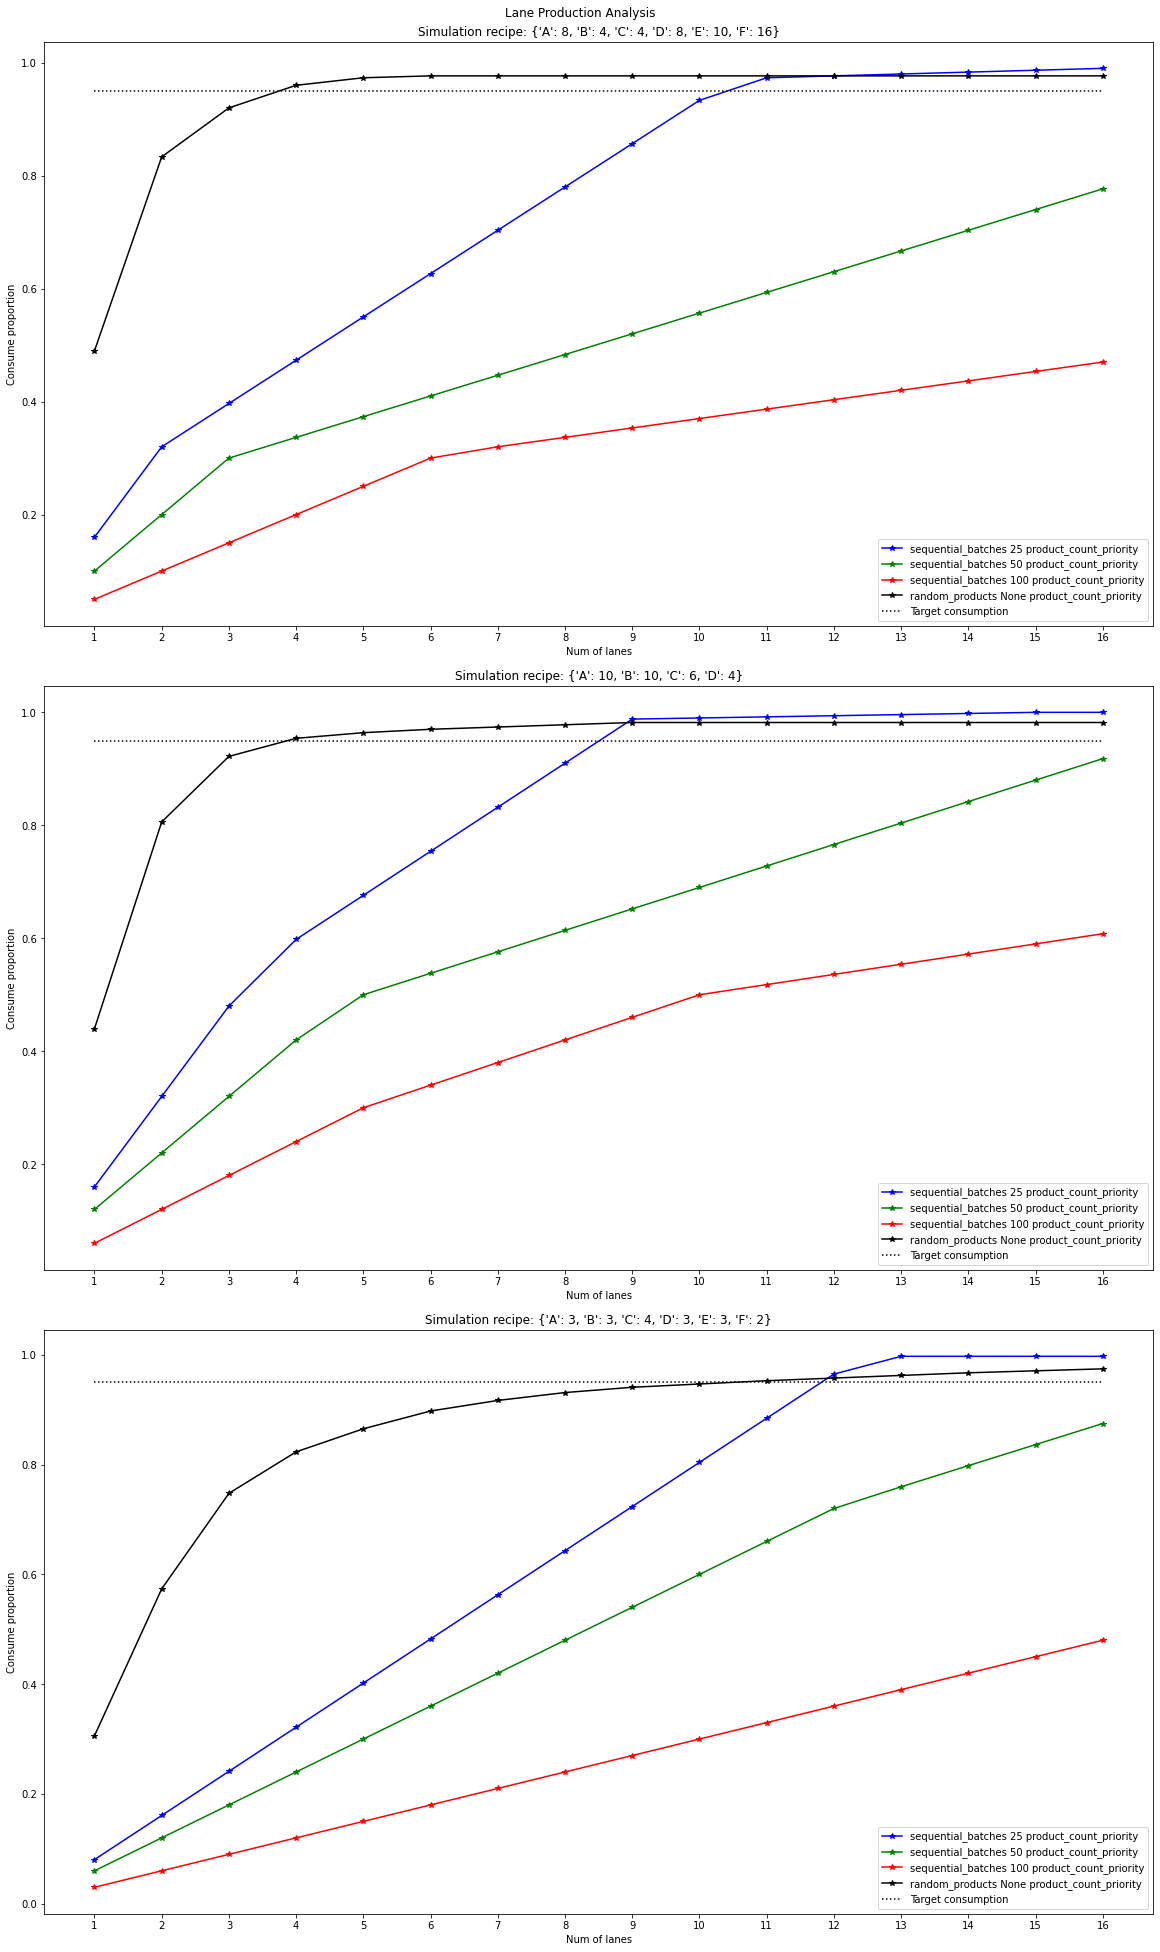

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, axs = plt.subplots(
    len(recipes), figsize=(16, 9 * len(recipes)), constrained_layout=True
)

fig.suptitle("Lane Production Analysis")

color_map = defaultdict(lambda: "k")
for batch_size, color in zip(batch_sizes, mcolors.BASE_COLORS.keys()):
    color_map[batch_size] = color

line_type_map = defaultdict(lambda: "-")

xx = list(range(1, 17))

for (recipe_index, infeed_type, batch_size) in sequences.keys():
    color = color_map[batch_size]
    line_type = line_type_map[infeed_type]

    if infeed_type in ["random_products", "sequential_batches"]:
        yy = get_the_ys(xx, infeed_type, recipe_index, batch_size)
        axs[recipe_index].plot(
            xx,
            yy,
            f"{line_type}{color}",
            marker="*",
            label=f"{infeed_type} {batch_size} {priority.__name__}",
        )

for recipe_index, recipe in enumerate(recipes):
    zz = np.ones(len(xx)) * 0.95
    axs[recipe_index].plot(xx, zz, f":k", label=f"Target consumption")
    axs[recipe_index].set_xticks(xx)
    axs[recipe_index].legend()
    axs[recipe_index].set_title(f"Simulation recipe: {recipe}")
    axs[recipe_index].set_xlabel("Num of lanes")
    axs[recipe_index].set_ylabel("Consume proportion")

plt.show()

In [11]:
batch_size = 50
num_of_lanes = 5

In [12]:
def create_subplot(recipe_index, infeed_type, batch_size=None):
    data = simulate(num_of_lanes, infeed_type, recipe_index, batch_size=batch_size)

    for lane, production in data["boxes_per_lane_per_frame"].items():
        arrays = np.array_split(
            production, range(products_per_min, len(production), products_per_min)
        )
        y = [a.sum() for a in arrays]
        axs[recipe_index].plot([0] + y, label=f"Lane {lane}")

    # combine all lanes
    x = np.array(list(data["boxes_per_lane_per_frame"].values())).sum(axis=0)
    arrays = np.array_split(x, range(products_per_min, len(x), products_per_min))
    y = [a.sum() for a in arrays]
    axs[recipe_index].plot([0] + y, label=f"All lanes")

    # optimality lines
    recipe = recipes[recipe_index]
    optimal_boxes_per_min = products_per_min / sum(recipe.values())
    optimal_boxes_per_min_per_lane = optimal_boxes_per_min / num_of_lanes
    axs[recipe_index].plot(
        [optimal_boxes_per_min] * (len(y) + 1), f":k", label=f"optimal_boxes_per_min"
    )
    axs[recipe_index].plot(
        [optimal_boxes_per_min_per_lane] * (len(y) + 1),
        f"-.k",
        label=f"optimal_boxes_per_min",
    )
    axs[recipe_index].legend()
    axs[recipe_index].set_title(f"Simulation recipe: {recipe}")
    axs[recipe_index].set_xlabel("Minutes")
    axs[recipe_index].set_ylabel("Boxes produced")

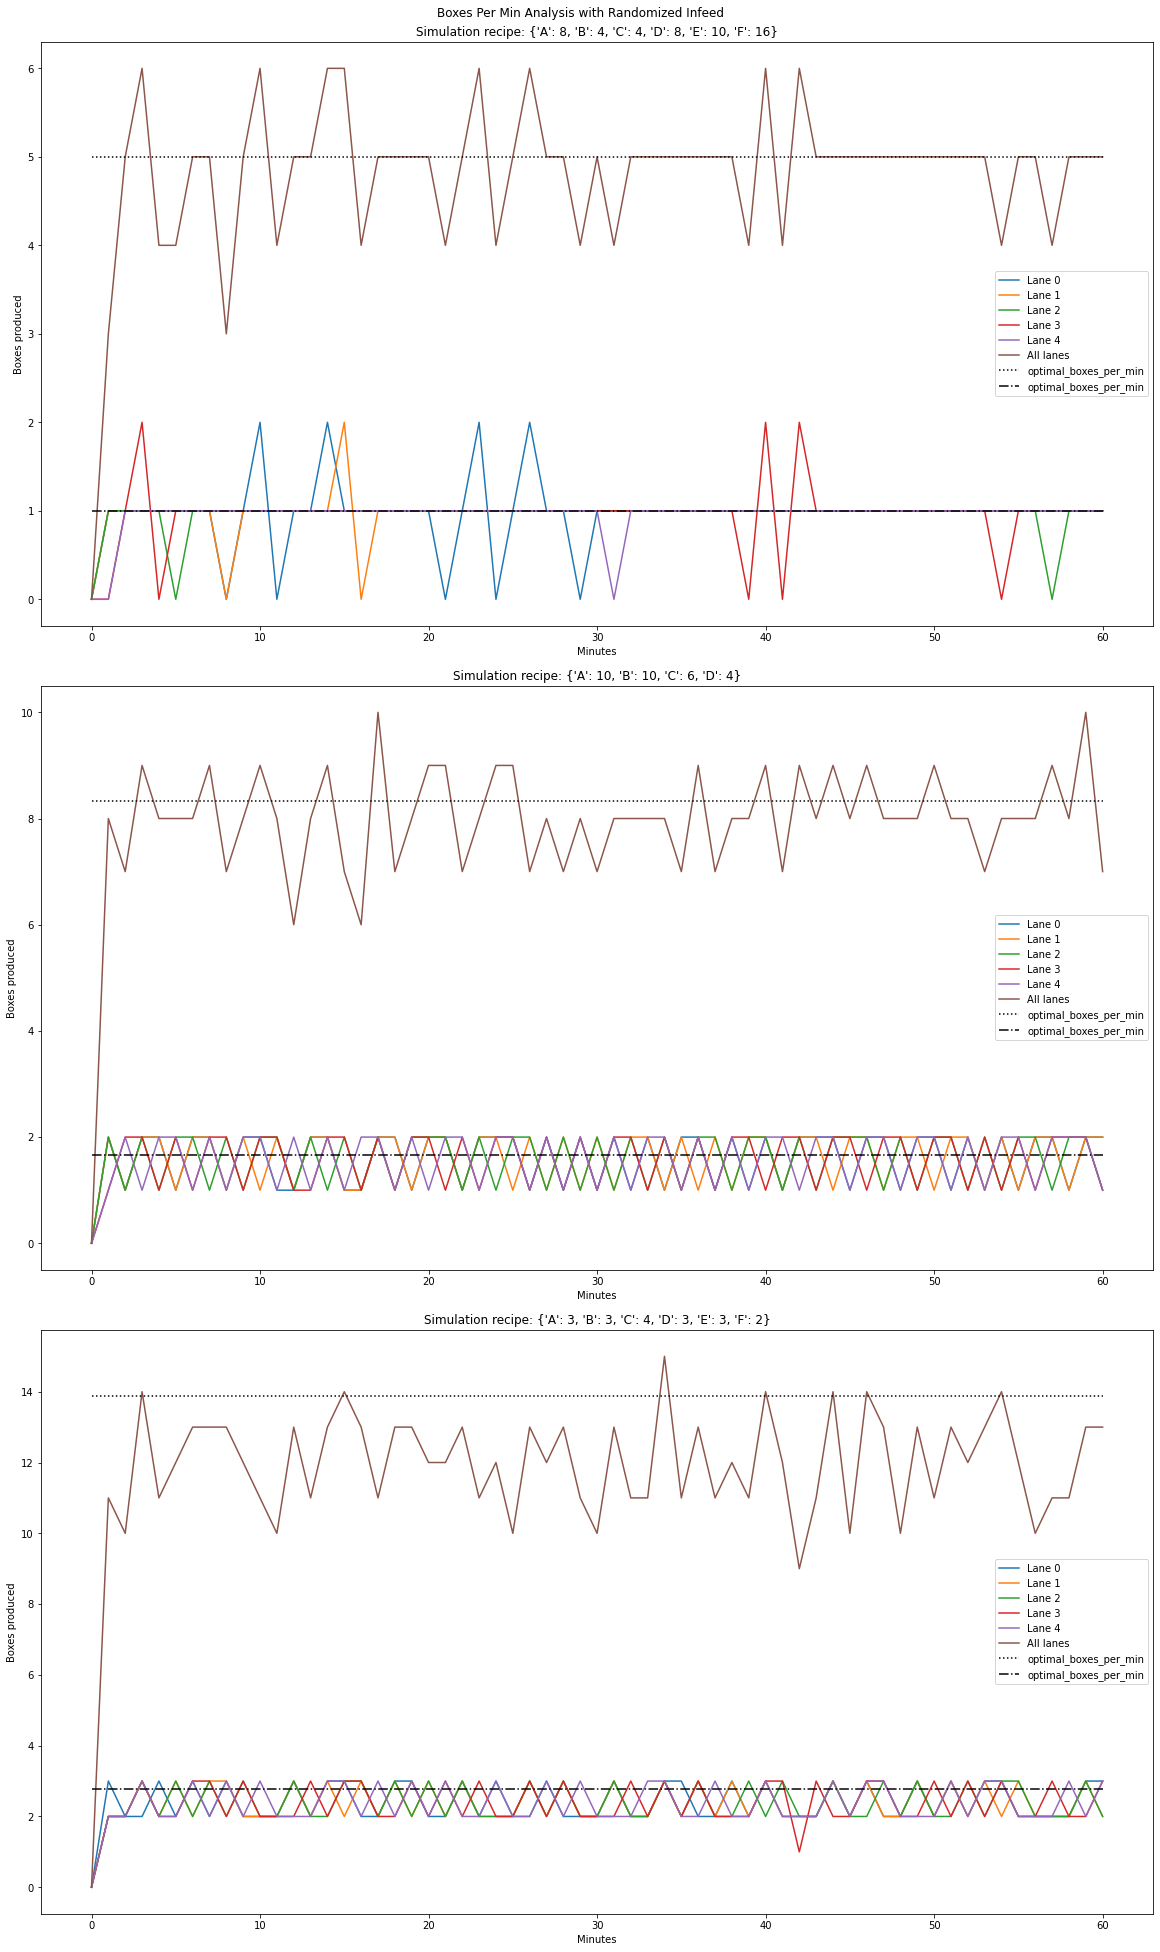

In [13]:
fig, axs = plt.subplots(
    len(recipes), figsize=(16, 9 * len(recipes)), constrained_layout=True
)

fig.suptitle("Boxes Per Min Analysis with Randomized Infeed")

for recipe_index, recipe in enumerate(recipes):
    create_subplot(recipe_index, "random_products")

plt.show()

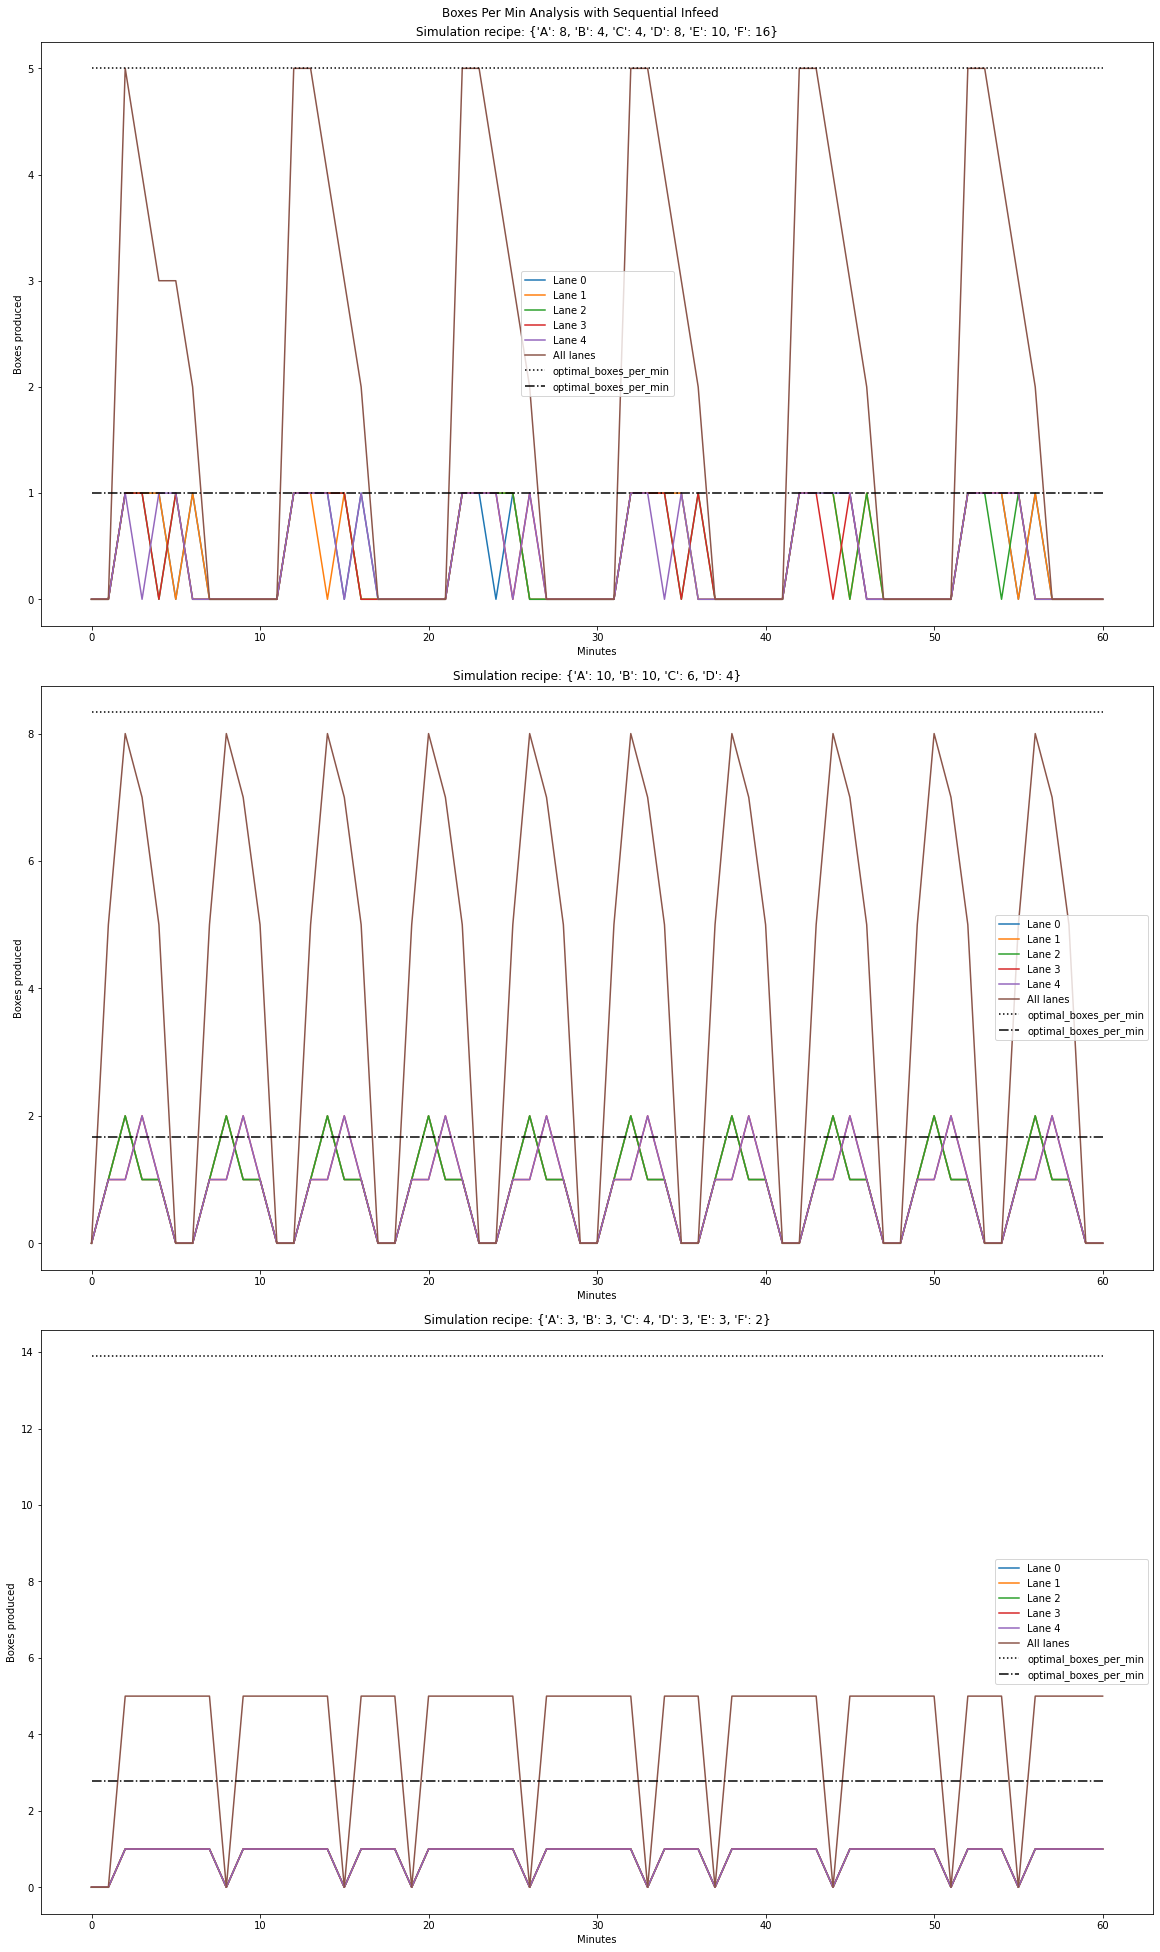

In [14]:
fig, axs = plt.subplots(
    len(recipes), figsize=(16, 9 * len(recipes)), constrained_layout=True
)

fig.suptitle("Boxes Per Min Analysis with Sequential Infeed")

for recipe_index, recipe in enumerate(recipes):
    create_subplot(recipe_index, "sequential_batches", batch_size=batch_size)

plt.show()

In [15]:
def avg_consumption_rate(x_num_of_lanes, y_lane_lock, infeed_type, batch_size=None):
    x, y = np.meshgrid(x_num_of_lanes, y_lane_lock)

    I, J = y.shape

    data = []
    
    for recipe_index in range(len(recipes)):
        z_arrays = []

        for i in range(I):
            global lane_lock
            lane_lock = y[i, 0]
            z_arrays.append(get_the_ys(x[i, :], infeed_type, recipe_index, batch_size=batch_size))

        data.append(np.array(z_arrays))

    tensor = np.array(data)
    
    return tensor.mean(axis=0)

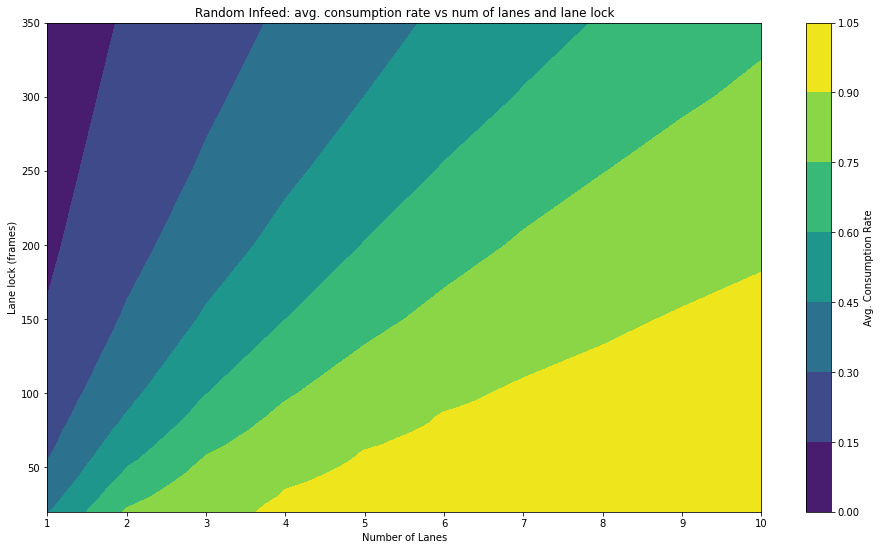

In [16]:
plt.figure(figsize=(16, 9))

x_num_of_lanes = list(range(1, 11))
# x_num_of_lanes = list(range(1, 6))
y_lane_lock = list(range(20, 100, 5)) + list(range(100, 400, 50))
# y_lane_lock = list(range(20, 100, 20))
z_avg_consumption_rate = avg_consumption_rate(x_num_of_lanes, y_lane_lock, "random_products") 

plt.contourf(x_num_of_lanes, y_lane_lock, z_avg_consumption_rate, vmin=0, vmax=1)
plt.colorbar(label="Avg. Consumption Rate")

plt.title(f"Random Infeed: avg. consumption rate vs num of lanes and lane lock")
plt.ylabel("Lane lock (frames)")
plt.xlabel("Number of Lanes")

plt.show()

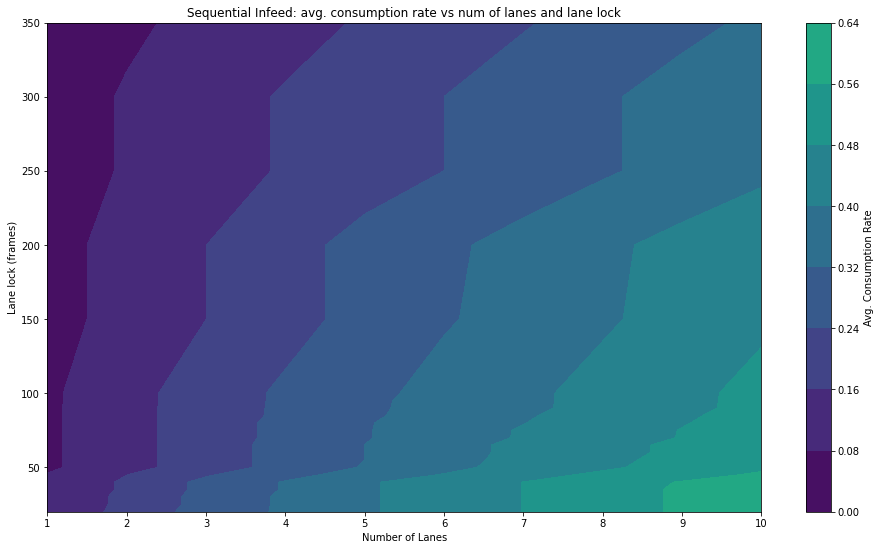

In [17]:
plt.figure(figsize=(16, 9))

x_num_of_lanes = list(range(1, 11))
# x_num_of_lanes = list(range(1, 6))
y_lane_lock = list(range(20, 100, 5)) + list(range(100, 400, 50))
# y_lane_lock = list(range(20, 100, 20))
z_avg_consumption_rate = avg_consumption_rate(x_num_of_lanes, y_lane_lock, "sequential_batches", 50) 

plt.contourf(x_num_of_lanes, y_lane_lock, z_avg_consumption_rate, vmin=0, vmax=1)
plt.colorbar(label="Avg. Consumption Rate")

plt.title(f"Sequential Infeed: avg. consumption rate vs num of lanes and lane lock")
plt.ylabel("Lane lock (frames)")
plt.xlabel("Number of Lanes")

plt.show()

In [18]:
# reset global variable
lane_lock = 25

In [19]:
import string


def generate_random_recipes(
    num_of_recipes, min_num_of_products, max_num_of_products, lower, upper
):
    recipes = []
    for r in range(num_of_recipes):
        recipe = {}

        for product in string.ascii_uppercase[
            : np.random.randint(min_num_of_products, high=max_num_of_products)
        ]:
            recipe[product] = np.random.randint(lower, high=upper)

        recipes.append(recipe)

    return recipes

In [20]:
recipes = generate_random_recipes(60, 3, 6, 2, 16)
recipes

[{'A': 3, 'B': 13, 'C': 2},
 {'A': 10, 'B': 2, 'C': 14, 'D': 4},
 {'A': 4, 'B': 2, 'C': 9, 'D': 15, 'E': 4},
 {'A': 9, 'B': 3, 'C': 6, 'D': 11},
 {'A': 2, 'B': 7, 'C': 3},
 {'A': 11, 'B': 14, 'C': 5, 'D': 4},
 {'A': 13, 'B': 14, 'C': 4, 'D': 4},
 {'A': 11, 'B': 8, 'C': 11, 'D': 3, 'E': 6},
 {'A': 11, 'B': 2, 'C': 2, 'D': 10, 'E': 4},
 {'A': 8, 'B': 3, 'C': 14, 'D': 9},
 {'A': 2, 'B': 2, 'C': 7},
 {'A': 5, 'B': 11, 'C': 10, 'D': 6, 'E': 5},
 {'A': 11, 'B': 12, 'C': 2, 'D': 4, 'E': 9},
 {'A': 4, 'B': 11, 'C': 5, 'D': 4, 'E': 11},
 {'A': 5, 'B': 11, 'C': 7, 'D': 7},
 {'A': 15, 'B': 8, 'C': 13},
 {'A': 13, 'B': 3, 'C': 13},
 {'A': 14, 'B': 6, 'C': 3, 'D': 6, 'E': 12},
 {'A': 12, 'B': 14, 'C': 11, 'D': 13, 'E': 12},
 {'A': 6, 'B': 13, 'C': 8, 'D': 5},
 {'A': 12, 'B': 13, 'C': 9, 'D': 2},
 {'A': 15, 'B': 4, 'C': 11, 'D': 9, 'E': 4},
 {'A': 8, 'B': 9, 'C': 3, 'D': 9, 'E': 11},
 {'A': 15, 'B': 3, 'C': 8, 'D': 4, 'E': 7},
 {'A': 7, 'B': 12, 'C': 7},
 {'A': 10, 'B': 8, 'C': 9, 'D': 8, 'E': 9},
 

In [21]:
sequences = create_infeed_types()

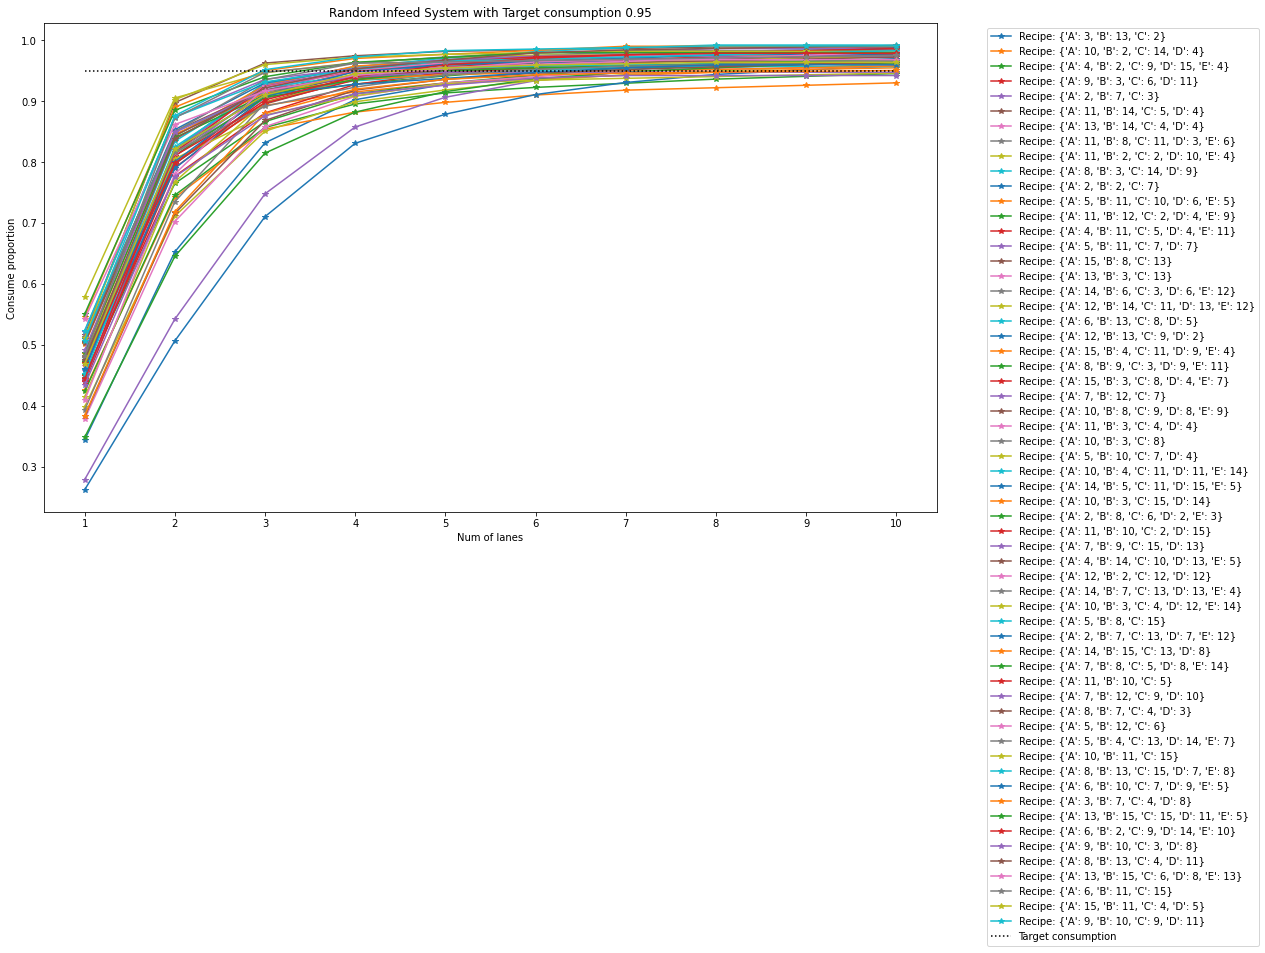

In [22]:
plt.figure(figsize=(16, 9))

xx = list(range(1, 11))
arrays = []
for recipe_index, recipe in enumerate(recipes):
    yy = get_the_ys(xx, "random_products", recipe_index)
    arrays.append(yy)
    plt.plot(xx, yy, marker="*", label=f"Recipe: {recipe}")

target_consumption = 0.95
zz = np.ones(len(xx)) * target_consumption
plt.plot(xx, zz, f":k", label=f"Target consumption")

plt.xticks(xx)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")

plt.title(f"Random Infeed System with Target consumption {target_consumption}")
plt.xlabel("Num of lanes")
plt.ylabel("Consume proportion")

plt.show()

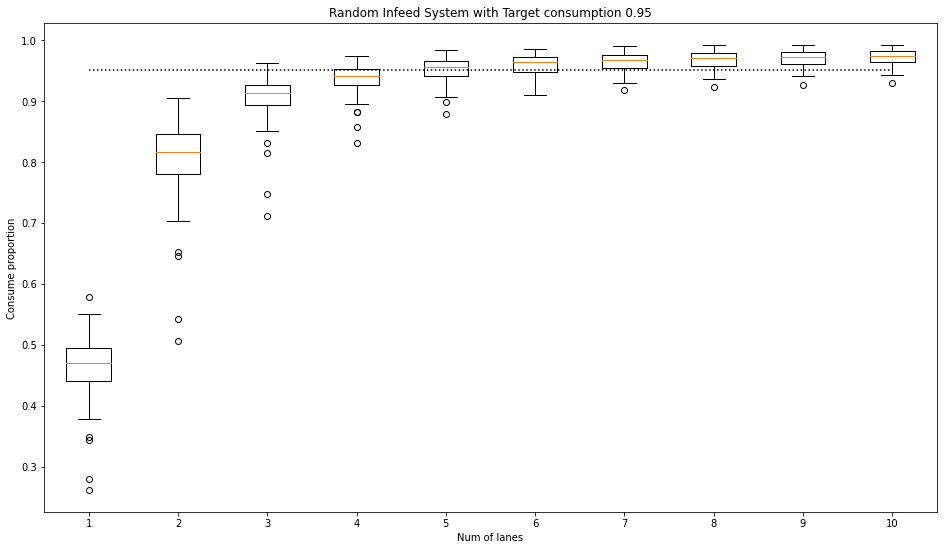

In [23]:
plt.figure(figsize=(16, 9))

plt.boxplot(np.array(arrays))

zz = np.ones(len(xx)) * target_consumption
plt.plot(xx, zz, ":k")

plt.title(f"Random Infeed System with Target consumption {target_consumption}")
plt.xlabel("Num of lanes")
plt.ylabel("Consume proportion")

plt.show()